# **04. 위성 이미지 분류**

## **4-1. 텐서플로 데이터셋 로드**

EuroSAT 데이터셋
* 인공위성에서 지표면을 촬영한 이미지와 토지이용분류 값이 정리되어 있는 데이터
* EU의 코페르니쿠스 지구 관측 프로그램에 의해 제공되는 공용 데이터셋인 Sentinel-2 위성이 관측한 이미지를 기반으로 만들어졌다.
* 총 27,000장의 위성 사진, 10개 토지이용분류 값이 매칭되어 제공된다.

**라이브러리**

In [3]:
pip install tensorflow-datasets

Note: you may need to restart the kernel to use updated packages.


In [4]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pyplot as plt

# Tensorflow Dataset 활용
import tensorflow_datasets as tfds

**EuroSAT 데이터셋 불러오기**

In [5]:
# EuroSAT 위성 사진 데이터셋 로드
DATA_DIR='dataset/'

(train_ds, valid_ds), info=tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                    shuffle_files=True,
                                    as_supervised=True,
                                    with_info=True,
                                    data_dir=DATA_DIR)
print(train_ds)
print(valid_ds)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

Shuffling dataset\eurosat\rgb\incomplete.WPRRXZ_2.0.0\eurosat-train.tfrecord*...:   0%|          | 0/27000 [00…

Dataset eurosat downloaded and prepared to dataset\eurosat\rgb\2.0.0. Subsequent calls will reuse this data.
<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


* (훈련 셋, 검증셋), 메타정보
* `with_info=True` : `info` 변수에 저장되는 메타 정보
  * `False` : 메타 정보 없이 (훈련 셋, 검증 셋) 형태의 투플로 반환된다.

* `data_dir=(파일 위치)` : 다운로드한 데이터셋 파일을 해당 위치에 저장한다.

* train 데이터만 제공한다.
  * `train_ds` : 훈련셋. 80% 데이터
  * `valid_ds` : 검증셋. 20% 데이터
  * (64, 64, 3)

In [6]:
# 메타 데이터 확인
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_dir='dataset\\eurosat\\rgb\\2.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('imag

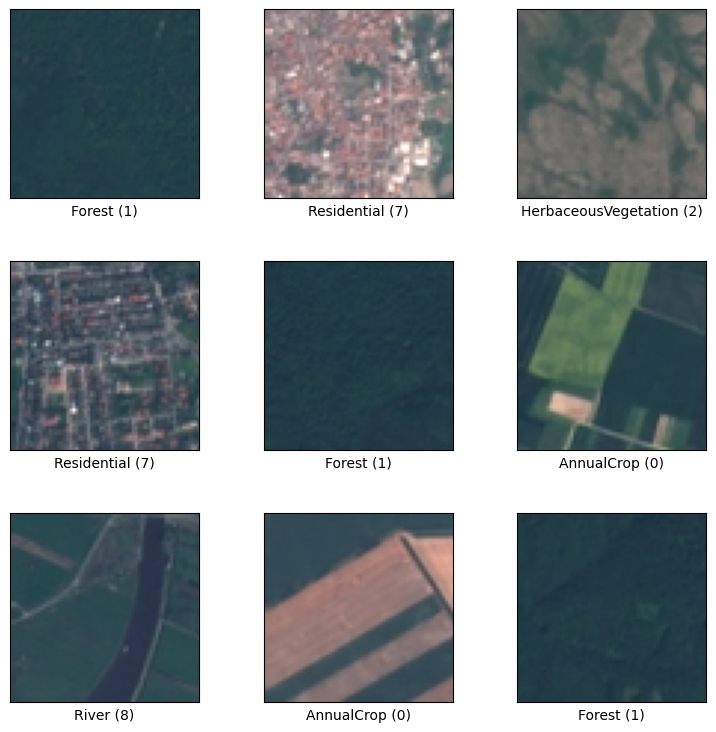

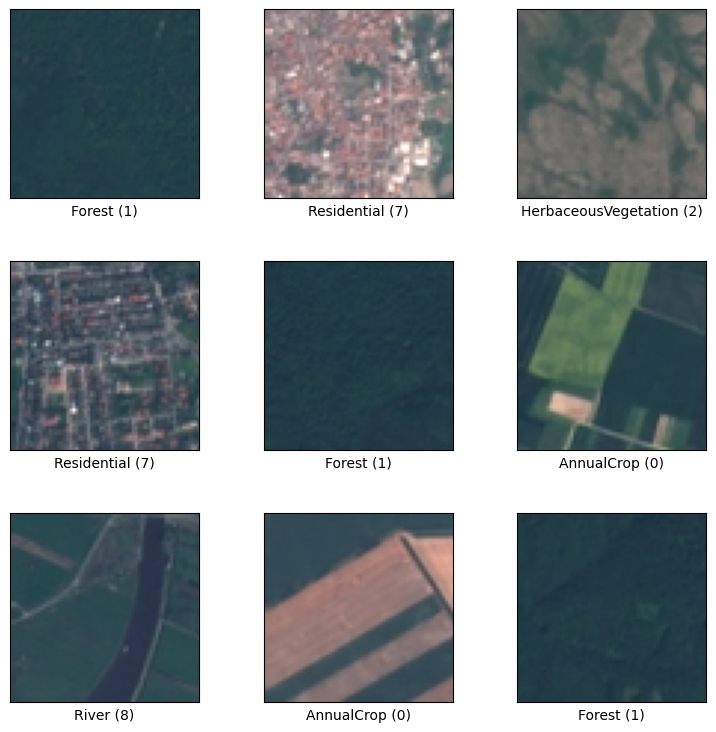

In [7]:
# 데이터 확인
tfds.show_examples(train_ds, info)

,image,label
0,,5 (Pasture)
1,,7 (Residential)
2,,0 (AnnualCrop)
3,,1 (Forest)
4,,0 (AnnualCrop)
5,,2 (HerbaceousVegetation)
6,,9 (SeaLake)
7,,8 (River)
8,,2 (HerbaceousVegetation)
9,,9 (SeaLake)

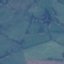
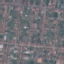
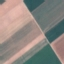
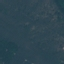
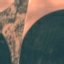
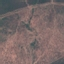
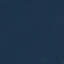
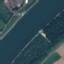
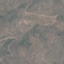
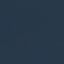

In [8]:
# as_dataframe 사용하여 샘플 출력
tfds.as_dataframe(valid_ds.take(10), info)

In [9]:
# 목표 클래스의 개수
NUM_CLASSES=info.features['label'].num_classes
print(NUM_CLASSES)

10


**문자열 변환**

In [10]:
# 숫자 레이블을 활용해 문자열 메타 데이터로 변환
print(info.features['label'].int2str(6))

PermanentCrop


## **4-2. 데이터 전처리**

텐서플로 연산은 `float32` 숫자 값을 사용하기 때문에, `cast` 함수를 사용하여 자료형을 `float32`로 변환해 준다.
* 입력 이미지는 0에서 255 범위의 픽셀 값을 갖기 때문에, 255로 나누어 정규화한다. (`preprocess_data` 함수)
* `map` 함수 : 사용자 정의 함수를 매핑하여 텐서플로 데이터셋에 적용하는 메소드로 전처리 과정에서 유용하다.
  * `num_parallel_calls=AUTOTUNE` : 텐서플로 병렬연산 처리를 자동으로 최적화한다.
    * 오토튠을 적용하지 않으면 데이터를 읽어서 매핑하고 훈련하는 과정을 순차적으로 처리하기 때문에 시간이 오래 걸린다.
    * 오토튠을 적용하면 하드웨어 리소스를 병렬로 매핑하여 처리하기 때문에 같은 작업을 훨씬 짧은 시간에 처리할 수 있다.

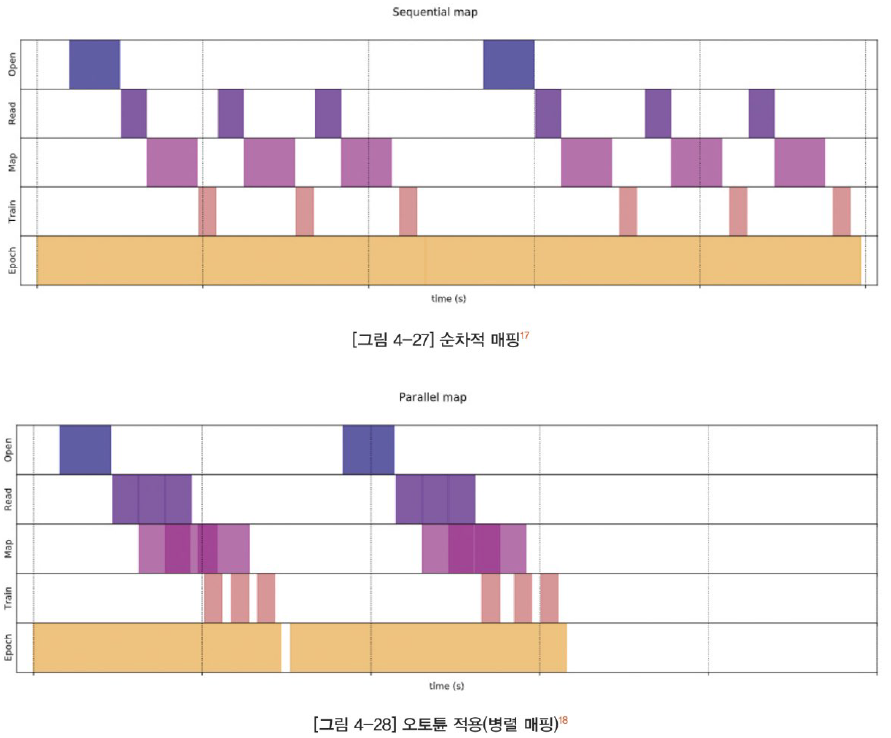

* `shuffle()` : 정규화 변환을 마친 데이터셋에 적용하면 순서를 랜덤하게 섞어 준다. 모델의 일반화된 성능을 높이기 위해 훈련 데이터셋에서 미니 배치를 생성할 때 입력 순서에 **무작위성**을 부여한다.
  * `BUFFER_SIZE=1000` : 처음 1,000개의 데이터를 가져온다.
  * `BATCH_SIZE=64` : 64개의 데이터를 랜덤하게 선택해서 하나의 배치를 구성한다.
    * 64개가 추출되어 미니 배치를 구성하고 학습에 사용되면, 다시 64개의 데이터가 버퍼에 추가되어 항상 1,000개의 버퍼를 구성한다.
    * `shuffle` 함수의 주요 파라미터인 `buffer_size`의 경우 데이터셋의 크기가 작은 경우 전체 데이터셋의 개수만큼 지정해 주는 것이 무작위성을 확보하는 데 유리하다. 하지만 데이터셋 개수가 많거나 이미지 파일의 크기가 커서 시스템상의 메모리에 전부 올릴 수 없는 경우 `buffer_size`를 1000으로 지정해 주는 것이 일반적이다.
    * 검증 데이터셋에서는 `shuffle` 함수를 사용할 필요가 없다. 모델의 가중치를 학습하는 데 사용되는 훈련 데이터셋의 순서는 랜덤하게 섞을 필요가 있지만, 검증 데이터셋은 평가 목적에 활용되기 때문에 순서는 큰 의미가 없다.
* `prefetch()` : 모델이 훈련을 진행하는 동안 다음에 입력할 데이터를 불러와서 미리 전처리를 하도록 시스템을 조율한다. 병렬 처리를 통해 모델 훈련 시간을 단축시켜 준다.

In [11]:
# 데이터 전처리 파이프라인
BATCH_SIZE=64
BUFFER_SIZE=1000

def preprocess_data(image, label):
  image=tf.cast(image, tf.float32)/255.
  return image, label

train_data=train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data=valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data=train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data=valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

## **4-3. 모델 훈련 및 검증**

배치 정규화, 합성곱, 풀링 레이어로 구성된 유닛 2개를 연결하고, Dense 레이어와 Dropout으로 구성된 최종 분류기를 갖는 딥러닝 모델을 Sequential API로 생성한다.

In [12]:
# Sequential API를 사용하여 샘플 모델 생성
def build_model():
  model=tf.keras.Sequential([
      # Convolutional 층
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D((2, 2)),

      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D((2, 2)),

      # Classifier 출력층
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
  ])

  return model

model=build_model()

예측 클래스가 10개인 다중 분류 문제에 맞게 손실함수와 평가지표를 설정하고, 모델을 50 epoch 훈련시킨다.

In [13]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 훈련
history=model.fit(train_data,
                  validation_data=valid_data,
                  epochs=50)

Epoch 1/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.2938 - loss: 2.0800 - val_accuracy: 0.4543 - val_loss: 1.6532
Epoch 2/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - accuracy: 0.4833 - loss: 1.4289 - val_accuracy: 0.6578 - val_loss: 1.0888
Epoch 3/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.5546 - loss: 1.2377 - val_accuracy: 0.7111 - val_loss: 0.8866
Epoch 4/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - accuracy: 0.5801 - loss: 1.1458 - val_accuracy: 0.6863 - val_loss: 0.9126
Epoch 5/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - accuracy: 0.6168 - loss: 1.0670 - val_accuracy: 0.7311 - val_loss: 0.7984
Epoch 6/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.6361 - loss: 1.0112 - val_accuracy: 0.7474 - val_loss: 0.7712
Epoch 7/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.6526 - loss: 0.9611 - val_accuracy: 0.7387 - val_loss: 0.7423
Epoch 8/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.6762 - loss: 0.8911 - 

모델은 10 epoch까지는 빠른 속도로 훈련이 진행되면서 손실함수가 급격히 감소한다. 하지만 그 이후로는 검증 셋에 대한 손실함수가 더 이상 줄어들지 않으면서 과대적합 경향을 나타낸다.

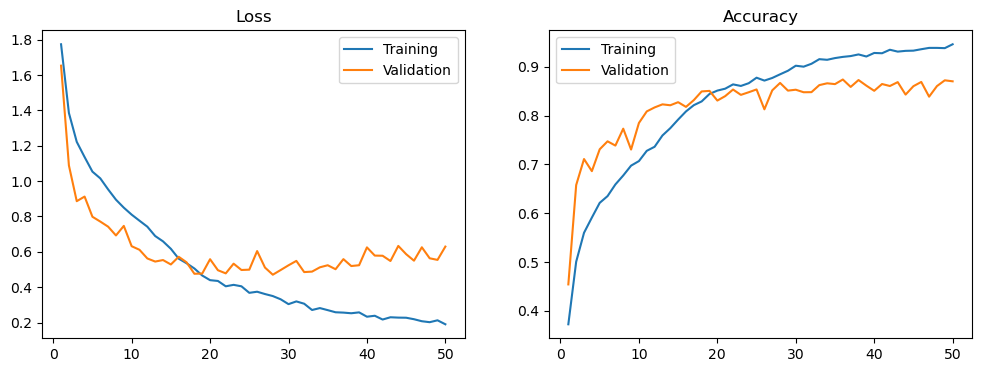

In [14]:
# 손실함수, 정확도 그래프 그리기
def plot_loss_acc(history, epoch):
  loss, val_loss=history.history['loss'], history.history['val_loss']
  acc, val_acc=history.history['accuracy'], history.history['val_accuracy']

  fig, axes=plt.subplots(1, 2, figsize=(12, 4))

  axes[0].plot(range(1, epoch+1), loss, label='Training')
  axes[0].plot(range(1, epoch+1), val_loss, label='Validation')
  axes[0].legend(loc='best')
  axes[0].set_title('Loss')

  axes[1].plot(range(1, epoch+1), acc, label='Training')
  axes[1].plot(range(1, epoch+1), val_acc, label='Validation')
  axes[1].legend(loc='best')
  axes[1].set_title('Accuracy')

  plt.show()

plot_loss_acc(history, 50)

## **4-4. 데이터 증강**

과대적합을 해소하는 기법인 배치 정규화, Dropout 등을 적용했음에도 과대적합이 발생하였다.

**데이터 증강** : 이미지 분류 문제에서 과대적합을 해소하고, 모델의 일반화된 Robust한 성능을 확보하는 기법
* 이미지 데이터에 여러 가지 변형을 주어서 훈련 데이터의 다양성을 확보하는 방식으로, 모델이 새로운 데이터에 대한 예측력을 강화하도록 하는 개념이다.

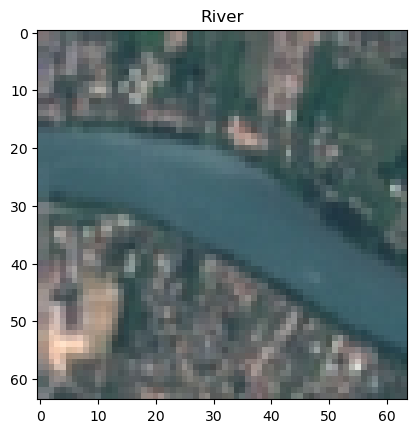

In [15]:
# 샘플 이미지
image_batch, label_batch=next(iter(train_data.take(1)))

image=image_batch[0]
label=label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features['label'].int2str(label));

In [16]:
# 데이터 증강 전후를 비교하는 시각화 함수 정의
def plot_augmentation(original, augmented):
  fig, axes=plt.subplots(1, 2, figsize=(12, 4))

  axes[0].imshow(original)
  axes[0].set_title('Original')

  axes[1].imshow(augmented)
  axes[1].set_title('Augmented')

  plt.show()

`tf.image` 모듈의 `flip_left_right` 함수 : 이미지 좌우 반전

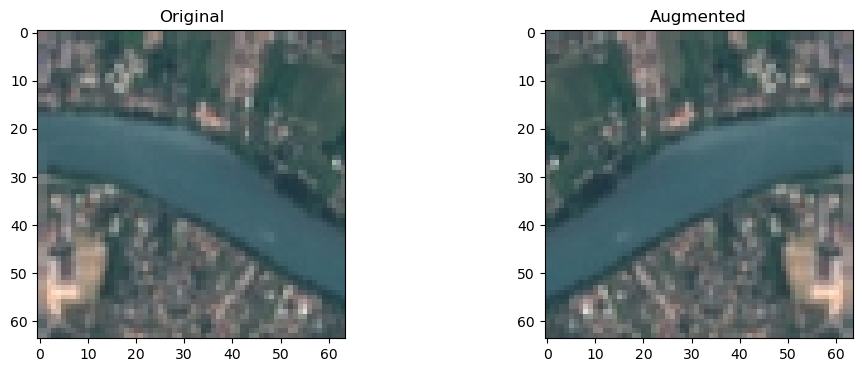

In [17]:
# 좌우 뒤집기
lr_flip=tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

`tf.image` 모듈의 `flip_up_down` 함수 : 이미지 상하 반전

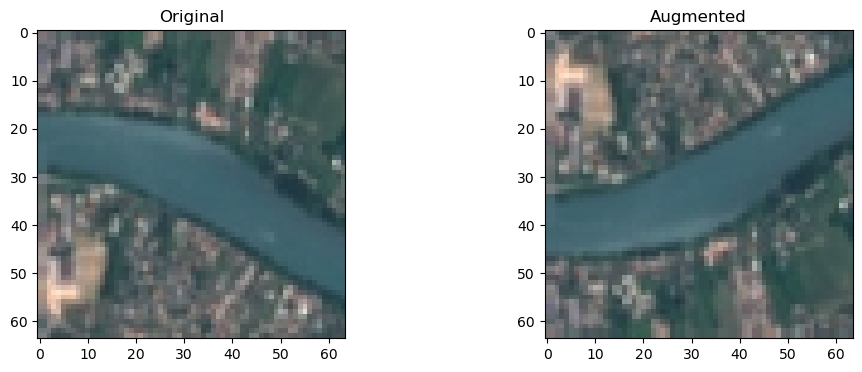

In [18]:
# 상하 뒤집기
ud_flip=tf.image.flip_up_down(image)
plot_augmentation(image, ud_flip)

`rot90` : 반시계 방향 90도 회전

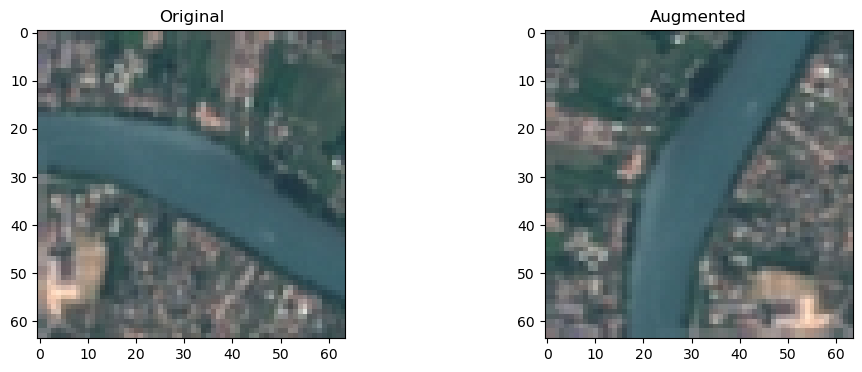

In [19]:
# 회전
rotate90=tf.image.rot90(image)
plot_augmentation(image, rotate90)

`transpose` 함수 : 이미지 텐서 행렬의 행과 열의 위치를 바꿔 준다(행렬 도치).

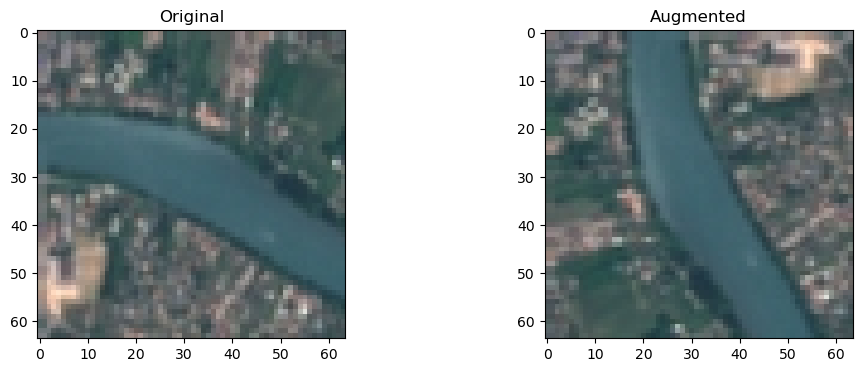

In [20]:
# transpose
transpose=tf.image.transpose(image)
plot_augmentation(image, transpose)

`central_crop` 함수 : 이미지 중심에서 일정 부분을 잘라내는 방법 구현

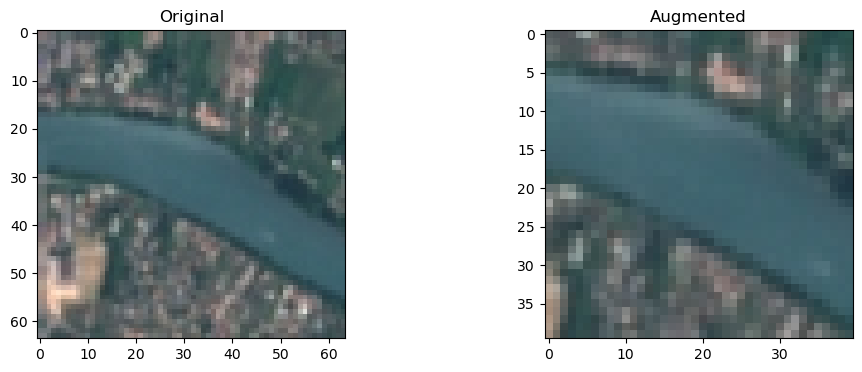

In [21]:
# 이미지 자르기1
crop1=tf.image.central_crop(image, central_fraction=0.6)
plot_augmentation(image, crop1)

* `resize_with_crop_or_pad` 함수 : 원본 이미지 키우기
* `random_crop` 함수 : 이미지 자르기
  * 원본 크기와 같게 자르면 원본 이미지가 상하좌우 랜덤한 방향으로 시프트(shift) 이동한다.

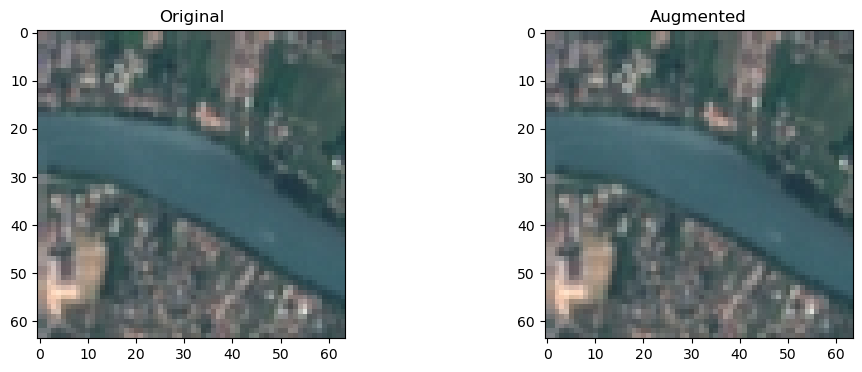

In [22]:
# 이미지 자르기2
img=tf.image.resize_with_crop_or_pad(image, 64+20, 64+20)
crop2=tf.image.random_crop(image, size=[64, 64, 3])
plot_augmentation(image, crop2)

**이미지 밝기 조정**

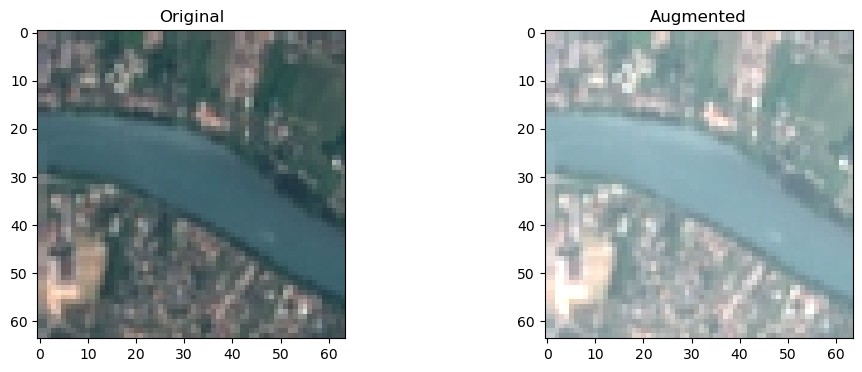

In [23]:
# 이미지 밝기
brightness=tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

**이미지 채도 변경**

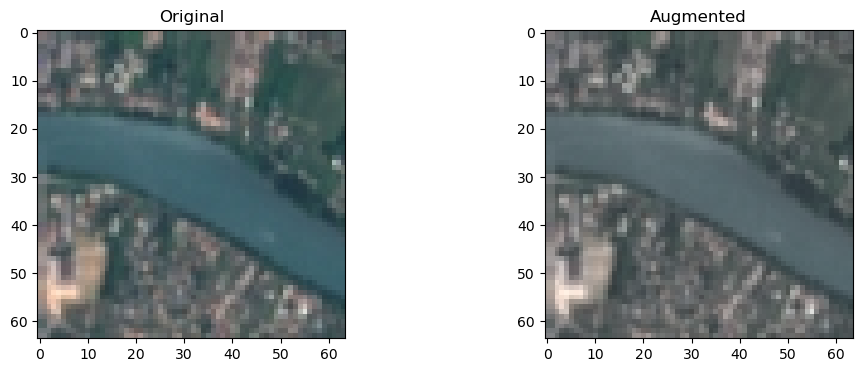

In [24]:
# 이미지 채도
saturation=tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image, saturation)

**이미지 대비(contrast) 조정**

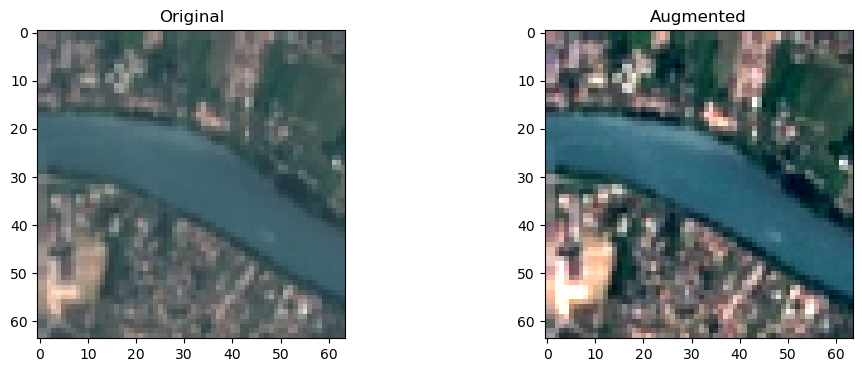

In [25]:
# 이미지 대비
contrast=tf.image.adjust_contrast(image, contrast_factor=2)
plot_augmentation(image, contrast)

**이미지 증강 및 전처리**
* `data_augmentation` 사용자 함수 정의
  * `tf.image` 모듈에서 지원하는 함수 중 `random_`으로 시작하는 함수 적용 : 이미지 증강 효과에 랜덤성을 부여한다.
* `map` 함수 : 원본 데이터셋에 적용
* `shuffle`, `batch` 함수 : 미니 배치로 만든다.

In [26]:
# 이미지 증강 전처리
def data_augmentation(image, label):
  image=tf.image.random_flip_left_right(image)
  image=tf.image.random_flip_up_down(image)
  image=tf.image.random_brightness(image, max_delta=0.3)
  image=tf.image.random_crop(image, size=[64, 64, 3])

  image=tf.cast(image, tf.float32)/255.

  return image, label

train_aug=train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug=valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_aug=train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug=valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

print(train_aug)
print(valid_aug)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


모델 인스턴스를 생성하고, 컴파일을 거쳐 50 epoch 동안 훈련시킨다.

In [27]:
# 모델 생성
aug_model=build_model()

# 모델 컴파일
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
aug_history=aug_model.fit(train_aug,
                          validation_data=valid_aug,
                          epochs=50)

Epoch 1/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 33s 80ms/step - accuracy: 0.2117 - loss: 2.3034 - val_accuracy: 0.3459 - val_loss: 1.8859
Epoch 2/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.3337 - loss: 1.7025 - val_accuracy: 0.4111 - val_loss: 1.5014
Epoch 3/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 27s 81ms/step - accuracy: 0.3765 - loss: 1.5765 - val_accuracy: 0.5104 - val_loss: 1.2877
Epoch 4/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 27s 80ms/step - accuracy: 0.4248 - loss: 1.4643 - val_accuracy: 0.5856 - val_loss: 1.2115
Epoch 5/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 26s 76ms/step - accuracy: 0.4777 - loss: 1.3935 - val_accuracy: 0.6120 - val_loss: 1.1363
Epoch 6/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.5031 - loss: 1.3100 - val_accuracy: 0.6507 - val_loss: 1.0754
Epoch 7/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - accuracy: 0.5304 - loss: 1.2500 - val_accuracy: 0.6893 - val_loss: 0.9817
Epoch 8/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - accuracy: 0.5534 - loss: 1.2086 - 

➡️ 데이터 증강 전과 모델의 성능 자체는 큰 차이가 없다.

**손실함수, 정확도 그래프**

훈련 셋과 검증 셋에 대한 손실함수는 50 epoch 동안 계속 줄어들고 정확도는 조금씩 우상향하면서 개선되고 있다.

➡️ 과대적합 문제가 상당히 해소되었다.

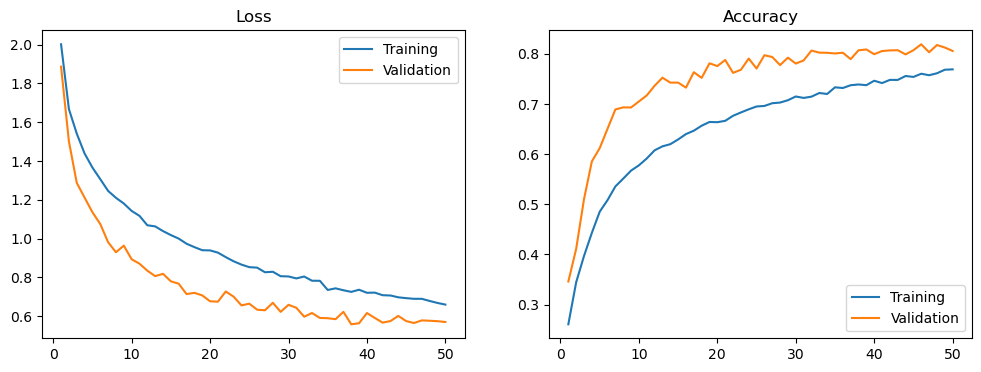

In [28]:
# 손실함수, 정확도 그래프
plot_loss_acc(aug_history, 50)

* 손실함수 그래프를 보면, 훈련 셋에 대한 손실함수보다 검증 셋에 대한 손실함수가 여전히 더 낮다. epoch 수를 더 늘려 모델을 더 훈련시키면 성능을 개선시킬 여지가 있다.

## **ResNet 사전 학습 모델**

* 이미지넷 경진 대회에서 우승한 모델로서 우수한 성능을 갖는다.
* 사전에 방대한 이미지로 훈련을 받은 딥러닝 모델의 구조와 가중치를 그대로 가져오고, 모델의 끝단에 위치하는 Top 층에 위성 이미지를 분류할 수 있는 최종 분류기를 추가하는 방식으로 구성한다.

➡️ 전이 학습(Transfer Learning)

* ResNet50V2 버전 사용
* 원래 ResNet 모델의 입력 크기는 (224, 224, 3)이지만, 케라스에서 이미지 크기를 우리가 지정한 크기로 맞춰 줄인다. 분류하려는 클래스 레이블의 개수 10개를 `classes` 속성에 지정한다.
* `include_top=False` : Top 층은 이미지넷 경진 대회에 맞는 분류기이기 때문에 제거한다. 제거된 부분에 우리가 해결하려는 문제에 맞는 최종 분류기를 대체해서 추가한다.

In [2]:
pip install --force-reinstall pydot==1.4.2 graphviz==0.20.1

  Using cached pydot-1.4.2-py2.py3-none-any.whl.metadata (8.0 kB)
  Using cached graphviz-0.20.1-py3-none-any.whl.metadata (12 kB)
Using cached pydot-1.4.2-py2.py3-none-any.whl (21 kB)
Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)
   ---------------------------------------- 0.0/106.9 kB ? eta -:--:--
   ----------- ---------------------------- 30.7/106.9 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 106.9/106.9 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.9
    Uninstalling pyparsing-3.0.9:
      Successfully uninstalled pyparsing-3.0.9
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3
  Attempting uninstall: pydot
    Found existing installation: pydot 3.0.2
    Uninstalling pydot-3.0.2:
      Successfully uninstalled pydot-3.0.2
Note: you may need to restart the kernel to use updated 

In [1]:
import shutil

if shutil.which("dot") is not None:
    print("Graphviz is installed and 'dot' is available in PATH.")
else:
    print("Graphviz is not installed or 'dot' is not in PATH.")

Graphviz is installed and 'dot' is available in PATH.


In [2]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.utils import plot_model

# Pre-trained 모델 생성
pre_trained_base = ResNet50V2(include_top=False,
                              weights='imagenet',
                              input_shape=[64, 64, 3])

# 가중치 고정
pre_trained_base.trainable = False

# 모델 시각화
plot_model(pre_trained_base, show_shapes=True, show_layer_names=True, to_file='resnet50.png')

NUM_CLASSES 변수는 위성 이미지의 클래스 레이블 개수인 10을 값으로 가지고 있다. 최종적으로 10개 클래스에 대한 다중 분류를 할 수 있도록 Dense 레이어의 노드 개수와 softmax 활성화 함수를 지정한다.

In [4]:
import tensorflow as tf

In [8]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pyplot as plt

# Tensorflow Dataset 활용
import tensorflow_datasets as tfds

In [9]:
# EuroSAT 위성 사진 데이터셋 로드
DATA_DIR='dataset/'

(train_ds, valid_ds), info=tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                    shuffle_files=True,
                                    as_supervised=True,
                                    with_info=True,
                                    data_dir=DATA_DIR)
print(train_ds)
print(valid_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [10]:
# 목표 클래스의 개수
NUM_CLASSES=info.features['label'].num_classes
print(NUM_CLASSES)

10


In [11]:
# Top 층에 Classifier 추가
def build_trainsfer_classifier():
  model=tf.keras.Sequential([
      # Pre-trained Base
      pre_trained_base,
      # Classifier 출력층
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
  ])

  return model

# 모델 구조
tc_model=build_trainsfer_classifier()
tc_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ ?                           │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,564,800 (89.89 MB)

23,564,800개는 훈련이 되지 않는(Non-trainable) 것으로 확인된다. 우리가 Top 층에 추가한 Dense 레이어들의 파라미터만 가중치가 업데이트된다.